In [ ]:
import numpy as np
import tensorflow as tf

from models import *
from utils import *
from data import * 

EPOCHS = 10
B = 16
W, H = 224, 224
M = 10
dA, dG = 48, 16
compr_size = 100

In [2]:
dataloader = Dataloader(path='../data/UCF-101/', frames_path='../data/UCF-101-train-1/')
dataloader.load_video_names()
dataloader.make_dirs()
dataloader.create_frames()

100%|██████████| 13320/13320 [15:04<00:00, 14.72it/s]


In [2]:
dataloader = Dataloader(path='../data/UCF-101/', frames_path='../data/UCF-101-train-1/')
x_train, x_val = dataloader.create_data(0, 10)
L = x_train.shape[0]
# x_train = np.reshape(x_train[:L-L%M], (-1, M, W, H, 3))
x_train = np.reshape(x_train[:L-L%M], (-1, W, H, 3*M))
L = x_val.shape[0]
# x_val = np.reshape(x_val[:L-L%M], (-1, M, W, H, 3))
x_val = np.reshape(x_val[:L-L%M], (-1, W, H, 3*M))

100%|██████████| 830/830 [00:01<00:00, 562.75it/s]


In [9]:
k = 10 # Compresiion parameter : k/48
model = tf.keras.Sequential()
x0 = tf.keras.layers.Input(shape=(W, H, 3*M))
# Encoder
x1 = tf.keras.layers.Conv2D(16, (5,5), padding='same', strides=2, activation='relu')(x0)
x2 = tf.keras.layers.Conv2D(32, (5,5), padding='same', strides=2, activation='relu')(x1)
# x2_ = tf.keras.layers.Permute((3,2,1,4))(x2)
# x3_ = AttentionBlock(dA, dG)(x2_)
# x3 = tf.keras.layers.Permute((3,2,1,4))(x3_)
x4 = tf.keras.layers.Conv2D(32, (5,5), padding='same', strides=1, activation='relu')(x2)
x5 = tf.keras.layers.Conv2D(32, (5,5), padding='same', strides=1, activation='relu')(x4)
x6 = tf.keras.layers.Conv2D(k, (5,5), padding='same', strides=1, activation='relu')(x5)
x7 = tf.keras.layers.Flatten()(x6)
print((W*H*3*M)//x7.shape[-1])
# Decoder
# x0t = tf.keras.layers.Reshape((M, W//4, H//4, -1))(x7)
# x0t_ = tf.keras.layers.Permute((3,2,1,4))(x0t)
# x1t_ = AttentionBlock(dA, dG)(x0t_)
# x1t = tf.keras.layers.Permute((3,2,1,4))(x1t_)
x2t = tf.keras.layers.Reshape((W//4, H//4, -1))(x7)
x3t = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=1, activation='relu')(x2t)
x4t = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=1, activation='relu')(x3t)
x5t = tf.keras.layers.Conv2DTranspose(32, (5,5), padding='same', strides=1, activation='relu')(x4t)
x6t = tf.keras.layers.Conv2DTranspose(16, (5,5), padding='same', strides=2, activation='relu')(x5t)
x7t = tf.keras.layers.Conv2DTranspose(3*M, (5,5), padding='same', strides=2, activation='sigmoid')(x6t)
# x8t = tf.keras.layers.Reshape((M, W, H, 3))(x7t)
# Model
model = tf.keras.Model(x0, x7t)
opt = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=opt, loss=loss_function)
model.summary()

48
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 30)]    0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 112, 112, 16)      12016     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 56, 56, 32)        12832     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 56, 32)        25632     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 56, 56, 32)        25632     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 56, 56, 10)        8010      
_________________________________________________________________
flatten_6 (Flatten)          (None, 31360)             0

In [12]:
# model.load_weights('../checkpoint/aeimage-1_10')
model.fit(x_train, x_train, validation_data=(x_val, x_val), shuffle=False, epochs=10, batch_size=32)
# model.save_weights('../checkpoint/aeimage-1_10')

Epoch 1/10
24/24 [==============================] - 95s 4s/step - loss: 0.0961 - val_loss: 0.0956
Epoch 2/10
24/24 [==============================] - 97s 4s/step - loss: 0.0958 - val_loss: 0.0954
Epoch 3/10
24/24 [==============================] - 98s 4s/step - loss: 0.0957 - val_loss: 0.0953
Epoch 4/10
24/24 [==============================] - 101s 4s/step - loss: 0.0956 - val_loss: 0.0953
Epoch 5/10
24/24 [==============================] - 97s 4s/step - loss: 0.0956 - val_loss: 0.0952
Epoch 6/10
24/24 [==============================] - 100s 4s/step - loss: 0.0956 - val_loss: 0.0952
Epoch 7/10
24/24 [==============================] - 94s 4s/step - loss: 0.0956 - val_loss: 0.0952
Epoch 8/10
24/24 [==============================] - 95s 4s/step - loss: 0.0956 - val_loss: 0.0952
Epoch 9/10
24/24 [==============================] - 96s 4s/step - loss: 0.0955 - val_loss: 0.0952
Epoch 10/10
 3/24 [==>...........................] - ETA: 1:25 - loss: 0.0981

KeyboardInterrupt: 

tf.Tensor(0.10282848, shape=(), dtype=float32)


TypeError: Invalid shape (224, 224, 30) for image data

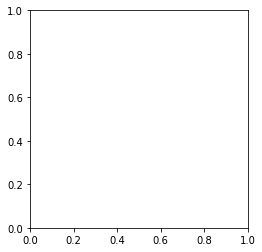

In [13]:
import matplotlib.pyplot as plt

y = model.predict(x_train[0:B])
img = x_train[0]
img_ = y[0]
print(loss_function(img, img_))
img_ = np.reshape(img_, (M,W,H,3))
img_ = img_[0]
# img_ = x_train[0, 8] + np.random.rand(W, H, 3)
# imgplot = plt.imshow(img)
imgplot = plt.imshow(img_)
plt.show()